In [151]:
import jax
import flax.linen as nn
from jax import numpy as jnp
import tensorflow as tf
import os
from typing import *
import optax
from flax.training import train_state
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [406]:
# Data Loading
BATCH_SIZE = 64
BUFFER_SIZE = 20_000
LATENT_DIM = 16
key = jax.random.PRNGKey(10)
GEN_LEARNING_RATE = 1e-4
DISC_LEARNING_RATE = 1e-4

In [284]:
key, key_generator = jax.random.split(key, 2)
jax.random.normal(key_generator, shape = (2,2))

Array([[ 0.4726117 ,  0.3460033 ],
       [-0.75647926,  0.07138681]], dtype=float32)

In [388]:
def load_data(batch_size, buffer_size):
    train_ds = tfds.load('mnist', split='train', shuffle_files=True)
    test_ds = tfds.load('mnist', split='test', shuffle_files = True)

    def preprocess(batch):
        image, label = batch["image"], batch["label"]
        
        image = (tf.cast(image, dtype = tf.float32) - 127.5) / 127.5

        return {"image": image}

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(buffer_size=buffer_size)
    train_ds = train_ds.batch(batch_size = batch_size, drop_remainder=True)
    train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    train_ds = train_ds.cache()
    
    test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size = batch_size, drop_remainder=True)
    test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache()
    
    train_ds = tfds.as_numpy(train_ds)
    test_ds = tfds.as_numpy(test_ds)
    
    return train_ds, test_ds

In [389]:
train_data, test_data = load_data(batch_size = BATCH_SIZE, buffer_size = BUFFER_SIZE)

In [390]:
for batch in train_data:
    print(batch["image"].shape)
    break

(64, 28, 28, 1)


2024-07-17 18:06:48.812155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-17 18:06:48.812400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [393]:
class Generator(nn.Module):
    in_channels: Any

    @nn.compact
    def __call__(self, x, train: bool):
        x = nn.Dense(7 * 7 * self.in_channels)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = x.reshape((-1, 7, 7, self.in_channels))
        x = nn.ConvTranspose(features=128, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.ConvTranspose(features=128, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=1, kernel_size=(7, 7), padding='SAME')(x)
        x = nn.tanh(x)
        
        return x

class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool):
        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=128, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = jnp.max(x, axis=(1, 2))
        x = nn.Dense(features=1)(x)
        return x

In [394]:
generator = Generator(in_channels = 16)
gen_x = jnp.ones(shape = (BATCH_SIZE, LATENT_DIM))
gen_params = generator.init(jax.random.key(10), x = gen_x, train = False)

gen_out = generator.apply(gen_params, x = gen_x, train = False)
print(gen_out.shape)

discriminator = Discriminator()
disc_x = jnp.ones(shape = (BATCH_SIZE, 28, 28, 1))
disc_params = discriminator.init(jax.random.key(11), x = disc_x, train = False)

disc_out = discriminator.apply(disc_params, x = disc_x, train = False)
print(disc_out.shape)

(64, 28, 28, 1)
(64, 1)


In [395]:
print(generator.tabulate(jax.random.key(0), x = gen_x, train = False))


                               Generator Summary                                
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ Generator     │ train: False  │ float32[64,2… │              │
│               │               │ x:            │               │              │
│               │               │ float32[64,1… │               │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ Dense_0       │ Dense         │ float32[64,1… │ float32[64,7… │ bias:        │
│               │               │               │               │ float32[784] │
│               │               │               │               │ kernel:      │
│               │               │               │               │ float32[16,… │
│               │          

In [396]:
print(discriminator.tabulate(jax.random.key(0), x = disc_x, train = False))


                             Discriminator Summary                              
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module        ┃ inputs          ┃ outputs        ┃ params          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         │ Discriminator │ train: False    │ float32[64,1]  │                 │
│         │               │ x:              │                │                 │
│         │               │ float32[64,28,… │                │                 │
├─────────┼───────────────┼─────────────────┼────────────────┼─────────────────┤
│ Conv_0  │ Conv          │ float32[64,28,… │ float32[64,14… │ bias:           │
│         │               │                 │                │ float32[64]     │
│         │               │                 │                │ kernel:         │
│         │               │                 │                │ float32[3,3,1,… │
│         │               │

In [397]:
# Define the loss function

def loss_function(logits, labels):
    
    """
    Arguments:
        logits : unnormalized logits output from discriminator
        labels : labels for the images
    """
    loss = optax.losses.sigmoid_binary_cross_entropy(logits, labels)
    return loss

@jax.jit
def train_step(batch, generator_state, discriminator_state, key):
    """
    """
    key, key_generator = jax.random.split(key)
    
    # We need random noise of shape -> (BATCH_SIZE, LATENT_DIM)
    noise = jax.random.normal(key = key, shape = (BATCH_SIZE, LATENT_DIM))
    real_data = batch["image"]
    
    # define loss function for generator model
    def gen_loss_fn(params):
        generated_data = generator_state.apply_fn(
            params,
            x = noise, train = True
        )
        logits = discriminator_state.apply_fn(
            discriminator_state.params,
            x = generated_data, train = True
        )

        loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))
        
        return loss, logits

    grads_gen_fn = jax.value_and_grad(fun = gen_loss_fn, has_aux = True)
    (gen_loss, gen_logits), grads_gen = grads_gen_fn(generator_state.params)

    new_generator_state = generator_state.apply_gradients(
        grads=grads_gen
    )

    noise = jax.random.normal(key, shape = (BATCH_SIZE, LATENT_DIM))
    generated_data = generator_state.apply_fn(
            generator_state.params,
            x = noise, train = True
        )
    
    def disc_loss_fn(params):
        

        all_data = jnp.concatenate([real_data, generated_data], axis = 0)
        all_labels = jnp.concatenate([
            jnp.ones(shape = (BATCH_SIZE, 1)),
            jnp.zeros(shape = (BATCH_SIZE, 1))
        ], axis = 0)
        
        logits = discriminator_state.apply_fn(
            params,
            x = all_data, train = True
        )

        loss = jnp.mean(loss_function(logits, all_labels))

        return loss, logits

    # This two line will calculate the loss value for given generated data
    grads_disc_fn = jax.value_and_grad(fun = disc_loss_fn, has_aux = True)
    (disc_loss, disc_logits), grads_disc = grads_disc_fn(discriminator_state.params)

    new_discriminator_state = discriminator_state.apply_gradients(
        grads = grads_disc
    )
    
    return new_generator_state, new_discriminator_state, gen_loss, disc_loss
    

In [407]:


def create_train_state(model, parameters, tx):
    state = train_state.TrainState.create(
        apply_fn = model.apply,
        params = parameters,
        tx = tx,
    )

    return state

# Generator
generator = Generator(in_channels = 16)
generator_parameters = generator.init(jax.random.key(0),
                                      x = jnp.ones(shape = (BATCH_SIZE, LATENT_DIM)),
                                     train = True)
gen_tx = optax.adam(learning_rate = GEN_LEARNING_RATE)
generator_state = create_train_state(model=generator, parameters=generator_parameters, tx=gen_tx)

# Discriminator
discriminator = Discriminator(name = "Discriminator")
discriminator_parameters = discriminator.init(jax.random.key(0),
                                             x = jnp.ones(shape = (BATCH_SIZE, 28, 28, 1)),
                                             train = True)
disc_tx = optax.adam(learning_rate = DISC_LEARNING_RATE)
discriminator_state = create_train_state(model=discriminator, parameters=discriminator_parameters, tx=disc_tx)

In [408]:
import time


def train_model(generator_state,
                discriminator_state,
                train_dataloader,
                test_dataloader,
                epochs,
                key):

    for epoch in tqdm(range(epochs)):
        train_loss = 0
        for i,batch in enumerate(train_dataloader):
            key, key_generator = jax.random.split(key, 2)
            generator_state, discriminator_state, gen_loss, disc_loss = train_step(
                batch = batch,
                generator_state = generator_state,
                discriminator_state = discriminator_state,
                key = key_generator
            )
            train_loss += (gen_loss + disc_loss) / 2
            if i % 100 == 0:
                print(f"Epoch: {epoch} | Batch : {i} | Generator Loss: {gen_loss:.04f} | Discriminator Loss: {disc_loss:.04f}")
        print(f"Epoch : {epoch} | Total Trainig Loss : {train_loss / len(train_dataloader)}")

    return generator_state, discriminator_state

In [409]:
generator_state, discriminator_parameters = train_model(generator_state, discriminator_state, train_data, test_data, 50, key)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Batch : 0 | Generator Loss: 0.6533 | Discriminator Loss: 0.5938
Epoch: 0 | Batch : 100 | Generator Loss: 1.3398 | Discriminator Loss: 0.1831
Epoch: 0 | Batch : 200 | Generator Loss: 3.2310 | Discriminator Loss: 0.0480
Epoch: 0 | Batch : 300 | Generator Loss: 0.5694 | Discriminator Loss: 0.4780
Epoch: 0 | Batch : 400 | Generator Loss: 0.7766 | Discriminator Loss: 0.3852
Epoch: 0 | Batch : 500 | Generator Loss: 0.9910 | Discriminator Loss: 0.4208
Epoch: 0 | Batch : 600 | Generator Loss: 1.0434 | Discriminator Loss: 0.4262
Epoch: 0 | Batch : 700 | Generator Loss: 1.2343 | Discriminator Loss: 0.4143
Epoch: 0 | Batch : 800 | Generator Loss: 1.2009 | Discriminator Loss: 0.4355
Epoch: 0 | Batch : 900 | Generator Loss: 1.1609 | Discriminator Loss: 0.4467
Epoch : 0 | Total Trainig Loss : 0.7544053196907043
Epoch: 1 | Batch : 0 | Generator Loss: 1.3158 | Discriminator Loss: 0.3516
Epoch: 1 | Batch : 100 | Generator Loss: 1.3964 | Discriminator Loss: 0.3409
Epoch: 1 | Batch : 200 | Gen

KeyboardInterrupt: 

In [401]:
noise = jax.random.normal(jax.random.key(0), shape = (BATCH_SIZE, LATENT_DIM))

In [402]:
out = generator.apply(generator_parameters, x = noise, train=False)

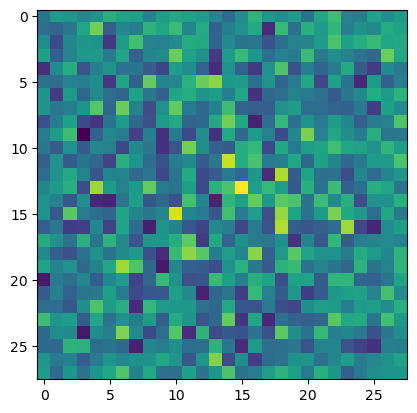

In [404]:
plt.imshow(jnp.clip((out[0] * 127.5) + 127.5, min = 0, max = 255))

In [ ]:
gen_tx.update()